In [1]:
import freud
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
hoomd.context.initialize("")

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 05/18/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [2]:
ptb7_path= "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
project = signac.get_project(ptb7_path)

In [3]:
state_dict= {"size": "small",
             "density": 0.8,
             "kT_reduced": 1.0,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}

job_list= project.find_jobs(state_dict)
for job in job_list:
    job_path = job.fn('trajectory.gsd')

In [4]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

## Diffraction Pattern

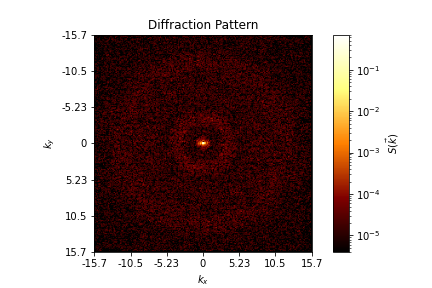

<Figure size 432x288 with 0 Axes>

In [5]:
f = gsd.pygsd.GSDFile(open(job_path, "rb"))
t = gsd.hoomd.HOOMDTrajectory(f)
last_frame = [-1]
frame = len(t)
snap = hoomd.data.gsd_snapshot(job_path, frame-1)
points = snap.particles.position
box = freud.Box.from_box(snap.box)
dp = freud.diffraction.DiffractionPattern(grid_size=1024,
                                  output_size=1024)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))

### Diffraction pattern with select atom types

In [6]:
total_atoms = 41+53+1+4+4
print(total_atoms)
# we're doing united atom--so our total atoms is 
total_atoms-=53
print(total_atoms)

103
50


In [7]:
with gsd.hoomd.open(name=job_path, mode='rb') as t:
    snap = t[-1]

In [8]:
# here are all the atom types in our system
snap.particles.types

['cc', 'cd', 'ca', 'os', 'c3', 'ss', 'c', 'o', 'f']

In [9]:
# here is the list of particles by typeid 
# e.g. ["cc", "cd", "cc"] --> [0,1,0]
print(len(snap.particles.typeid))
print(len(snap.particles.typeid)/(total_atoms*10))
snap.particles.typeid

50000
100.0


array([0, 1, 2, ..., 4, 2, 5], dtype=uint32)

In [16]:
atomtype = "ss"
points = snap.particles.position[
    snap.particles.typeid == snap.particles.types.index(atomtype)
]

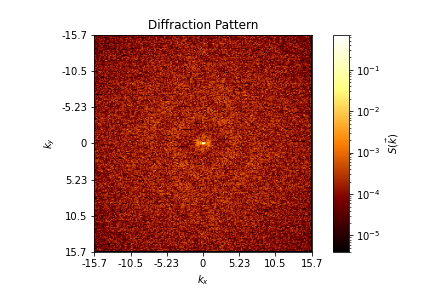

<Figure size 432x288 with 0 Axes>

In [17]:
box = freud.Box.from_box(snap.configuration.box)

dp = freud.diffraction.DiffractionPattern(
    grid_size=1024,
    output_size=1024
)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))